In [52]:
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
from matplotlib.pyplot import imshow
import math
import sklearn

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from collections import namedtuple
from ase.io import read
from ase.build import molecule
from ase import Atoms, Atom
from ase.visualize import view
from ase.geometry.analysis import Analysis
import plotly.graph_objects as go
from ase.data import vdw_radii
from ase.data.colors import cpk_colors, jmol_colors

import dscribe
from dscribe.descriptors import SOAP
from sklearn.decomposition import PCA

In [54]:
from soap_generation.alignment import align_elements
from soap_generation.augment import augment_elements

In [55]:
import pandas as pd
from pickle import load

In [56]:
import ternary

In [82]:
from decoder.soap import SOAPDecoder

decoder = SOAPDecoder(rcut=12, nmax=8, lmax=4)

def plot_density(coefficents, element=None, bond_width=0, resolution=10, opacity=0.1, atoms=None, is_diff=False, scale_limit=0):
    fig = go.Figure()
    
    X, Y, Z = np.mgrid[-10:10:(resolution * 1j), -10:10:(resolution * 1j), -10:10:(resolution * 1j)]
    values = np.zeros((resolution,resolution,resolution))
    
    indices = range(len(species))
    if atoms is not None:
        indices = [species.index(atoms)]
    
    for index in indices:
        values += decoder.density(coefficents, index, X, Y, Z)

    if scale_limit == 0:
        scale_limit = np.amax(np.abs(values))
    print(scale_limit)
    if is_diff:
        fig.add_trace(go.Volume(
            x=X.flatten(),
            y=Y.flatten(),
            z=Z.flatten(),
            value=values.flatten(),
            isomin=-scale_limit,
            isomax=scale_limit,
            opacity=opacity, # needs to be small to see through all surfaces
            opacityscale=[(0, 1), (0.5, 0), (1, 1)],
            surface_count=30, # needs to be a large number for good volume rendering
            colorscale="RdBu"
            #hoverinfo='skip',
        ))
    else:
        fig.add_trace(go.Volume(
            x=X.flatten(),
            y=Y.flatten(),
            z=Z.flatten(),
            value=values.flatten(),
            isomin=0,
            isomax=scale_limit,
            opacity=opacity, # needs to be small to see through all surfaces
            opacityscale=[(0, 0), (0.1, 0), (1, 1)],
            surface_count=30, # needs to be a large number for good volume rendering
            #hoverinfo='skip',
        ))

    
    if element is not None:
        element.rotate(90, 'z')
        for position, atomic_number in zip(element.get_positions(), element.get_atomic_numbers()):
            x1 = position[0]
            y1 = position[1]
            z1 = position[2]
            size = np.nan_to_num(vdw_radii[atomic_number]) * 0.3

            if size == 0:
                size = 0.5

            phi = np.linspace(0, 2*np.pi, 10)
            theta = np.linspace(-np.pi/2, np.pi/2, 10)
            phi, theta=np.meshgrid(phi, theta)

            x = np.cos(theta) * np.sin(phi) * size + x1
            y = np.cos(theta) * np.cos(phi) * size + y1
            z = np.sin(theta) * size + z1    
            color_string = "rgb(" + str(jmol_colors[atomic_number][0] * 230) + "," + str(jmol_colors[atomic_number][1] * 230) + "," + str(jmol_colors[atomic_number][2] * 230) + ")"

            fig.add_trace(go.Mesh3d({'x':x.flatten(), 
                                     'y':y.flatten(),
                                     'z':z.flatten(),
                                     'alphahull': 0, 
                                     'color': color_string,
                                    }))

        if bond_width > 0:
            bonds = Analysis(element).all_bonds[0]
            positions = element.get_positions()

            for index, bond in zip(range(len(positions)), bonds):
                x = []
                y = []
                z = []
                for atom in bond:
                    x.append(positions[index][0])
                    x.append(positions[atom][0])
                    x.append(positions[index][0])

                    y.append(positions[index][1])
                    y.append(positions[atom][1])
                    y.append(positions[index][1])

                    z.append(positions[index][2])
                    z.append(positions[atom][2])
                    z.append(positions[index][2])

                fig.add_trace(go.Scatter3d(
                    x = x,
                    y = y,
                    z = z,
                    mode = "lines",
                    line =
                        go.Line(
                            color = "rgb(10, 10, 10)",
                            width = bond_width
                        )
                ))

    fig.update_layout(
        height=1000,
        showlegend=False, 
        scene=dict(
            xaxis=dict(showticklabels=False, visible=False),
            yaxis=dict(showticklabels=False, visible=False),
            zaxis=dict(showticklabels=False, visible=False),
        ))
    fig.show()

In [83]:
def plot_density_diff(shap, coefficents, scaler, element=None, bond_width=0, resolution=10, opacity=0.1, atoms=None, scale_limit=0):  
    sc_scaled = scaler.inverse_transform(coefficents + shap)
    c_scaled = scaler.inverse_transform(coefficents)
    coeffs = sc_scaled - c_scaled
    
    plot_density(coeffs, element, bond_width, resolution, opacity, atoms, is_diff=True, scale_limit=scale_limit)

# Load data

In [84]:
def reg_stats(y_true,y_pred,scaler=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if scaler:
        y_true_unscaled = scaler.inverse_transform(y_true)
        y_pred_unscaled = scaler.inverse_transform(y_pred)
    r2 = sklearn.metrics.r2_score(y_true,y_pred)
    mae = sklearn.metrics.mean_absolute_error(y_true_unscaled, y_pred_unscaled)
    return r2,mae

In [85]:
dir = "../out/interpol3_8-4/"
#sample = "8:4:0.2"
#trainX = np.load(dir + "features_train.npy")
#trainY = np.load(dir + "labels_train.npy")

valX = np.load(dir + "features_val.npy")
valY = np.load(dir + "labels_val.npy")
valNames = np.load(dir + "names_val.npy")

testX = np.load(dir + "features_test.npy")
testY = np.load(dir + "labels_test.npy")
testNames = np.load(dir + "names_test.npy")

barrierScaler = load(open(dir + 'barrierScaler.pkl', 'rb'))
soapScaler = load(open(dir + 'featureScaler.pkl', 'rb'))

model_full = tf.keras.models.load_model(dir + "model.h5")

In [98]:
valElements = []
for name in valNames:
    valElements.append(read("../data/coordinates_molSimplify/" + name))

testElements = []
for name in testNames:
    testElements.append(read("../data/coordinates_molSimplify/" + name))

In [99]:
#trainX = trainX.reshape(-1, 12, int(trainX.shape[2] / 12), 1)
testX = testX.reshape(-1, 12, 200, 1)
valX = valX.reshape(-1, 12, 200, 1)
#trainY = trainY.flatten()
testY = testY.flatten()
valY = valY.flatten()

R^2 Val: 0.9484170131179032
MAE Val: 0.6472998512463692

R^2 Test: 0.9615656318509507
MAE Test: 0.5863032910029095


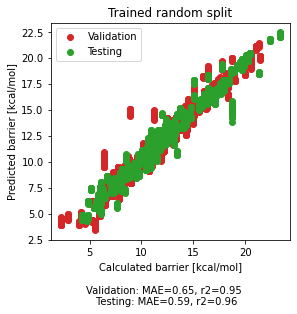

In [100]:
r2_val, mae_val = reg_stats(valY.flatten(), model_full.predict(valX), barrierScaler)
r2_test, mae_test = reg_stats(testY.flatten(), model_full.predict(testX), barrierScaler)

print("R^2 Val: " + str(r2_val))
print("MAE Val: " + str(mae_val))
print("")
print("R^2 Test: " + str(r2_test))
print("MAE Test: " + str(mae_test))

val_y_pred = barrierScaler.inverse_transform(model_full.predict(valX))
val_y_real = barrierScaler.inverse_transform(valY)

test_y_pred = barrierScaler.inverse_transform(model_full.predict(testX))
test_y_real = barrierScaler.inverse_transform(testY)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(val_y_real, val_y_pred, marker="o", c="C3", label="Validation")
ax.scatter(test_y_real, test_y_pred, marker="o", c="C2", label="Testing")
ax.set_aspect('equal')
ax.set_xlabel("Calculated barrier [kcal/mol]")
ax.set_ylabel("Predicted barrier [kcal/mol]")
ax.legend(loc="upper left")

plt.title("Trained random split")
#plt.savefig("../figs/scatter_" + str(nmax) + "-" + str(lmax) + "-" + str(split) + ".png")
txt = "Validation: MAE={:2.2f}, r2={:2.2f} \n Testing: MAE={:2.2f}, r2={:2.2f}".format(mae_val, r2_val, mae_test, r2_test)
fig.text(.5, -0.1, txt, ha='center')

plt.show()

In [101]:
aug_steps = 30

#trainX = trainX.reshape(-1, aug_steps, 12, 200, 1)
testX = testX.reshape(-1, aug_steps, 12, 200, 1)
valX = valX.reshape(-1, aug_steps, 12, 200, 1)
#trainY = trainY.reshape(-1, aug_steps)
testY = testY.reshape(-1, aug_steps)
valY = valY.reshape(-1, aug_steps)

# Compute gradient

In [102]:
def compute_gradient(model, sample, epsilon=1):
    gradient = np.zeros(sample.flatten().shape)
    
    # Scedule all gradients to be computed
    gradients = []
    for index in range(len(gradient)):
        direction = np.zeros(sample.flatten().shape)
        direction[index] = epsilon
        
        gradients += [(sample.flatten() + direction).reshape(sample.shape)]
    
    
    gradients = np.array(gradients)
    new_shape = [-1] + list(sample.shape)

    predictions = model.predict(gradients.reshape(new_shape))
    
    value = model.predict(np.array([sample]))
    
    gradients = (predictions - value) / epsilon
    
    return gradients.reshape(sample.shape)

In [109]:
#index1 = np.where(valNames=="ir_tbp_1_dft-pme3_1_dft-py_1_dft-iacn_1_chloride_1_smi1_1_s_1")[0]
#index2 = np.where(valNames=="ir_tbp_1_dft-pme3_1_dft-py_1_dft-iacn_1_chloride_1_smi1_1_s_1")[0]
#index3 = np.where(valNames=="ir_tbp_1_dft-pme3_1_dft-py_1_dft-iacn_1_chloride_1_smi1_1_s_1")[0]

index1 = 75
index2 = 42
index3 = 102

In [110]:
features1 = testX[index1][0].reshape(12, 200, 1)
features2 = testX[index2][0].reshape(12, 200, 1)
features3 = testX[index3][0].reshape(12, 200, 1)

barrier1 = barrierScaler.inverse_transform(testY[index1])[0]
barrier2 = barrierScaler.inverse_transform(testY[index2])[0]
barrier3 = barrierScaler.inverse_transform(testY[index3])[0]

name1 = testNames[index1]
name2 = testNames[index2]
name3 = testNames[index3]

element1 = testElements[index1]
element2 = testElements[index2]
element3 = testElements[index3]

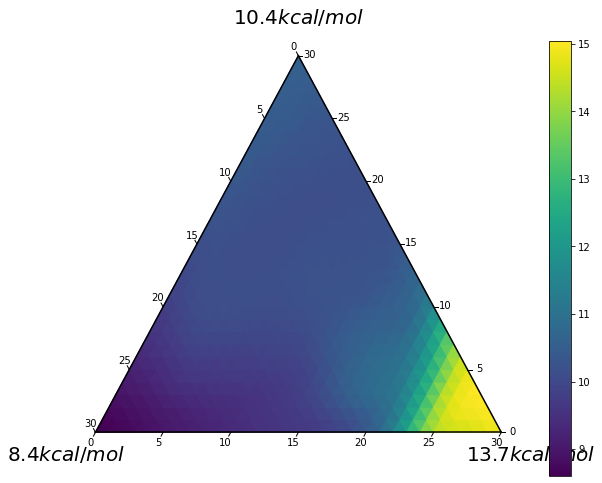

In [111]:
import math
from matplotlib import pyplot as plt
import ternary


def interpoaltion_mixing(x, y, z, scale):
    feature = (x/scale) * features1 + (y/scale) * features2 + (z/scale) * features3
    feature = feature.reshape(12, 200, 1)
    #barrier = model_full.predict(feature)[0]
    return feature

def generate_heatmap_data(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    features = []
    indices = []
    for (i, j, k) in simplex_iterator(scale):
        features.append(interpoaltion_mixing(i, j, k, scale))
        indices.append((i,j,k))
        
    #features = soapScaler.transform(np.array(features).reshape(-1, 2400)).reshape(-1, 12,200,1)
    features = np.array(features)
    #predictions = model_full.predict(soapScaler.inverse_transform(features.reshape(-1, 2400)).reshape(-1, 12, 200,1))
    predictions = model_full.predict(features)
    predictions = barrierScaler.inverse_transform(predictions)

    for index, prediction in zip(indices, predictions):
        d[index] = prediction[0]
    
    return d


scale = 30
data = generate_heatmap_data(scale)
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(10, 8)
tax.heatmap(data, cmap=None)
tax.boundary()
tax.ticks(axis='lbr', linewidth=1, multiple=5)
#tax.set_title("Ternary Plot")
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

fontsize=20
tax.right_corner_label("$ {} kcal/mol$".format(barrier1), fontsize=fontsize)
tax.top_corner_label("$ {} kcal/mol$".format(barrier2), fontsize=fontsize)
tax.left_corner_label("$ {} kcal/mol$".format(barrier3), fontsize=fontsize)

plt.show()

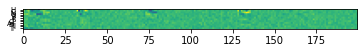

In [112]:
index = 0
image = features1
gradient = compute_gradient(model_full, image.reshape(12,200), epsilon=3).reshape(1,12,200,1)

species = ["H","C","N","O","F","P","S","Cl","As","Br","I","Ir"]

plt.imshow(gradient.reshape(12,200))
y_axis = np.arange(0, 12, 1)
plt.yticks(y_axis, species)
plt.yticks(fontsize=7)
plt.show()

In [116]:
print(element1)
plot_density_diff(gradient.flatten(), features1.flatten(), soapScaler, element1, bond_width=4, opacity=1, resolution=10, atoms="As")

Atoms(symbols='IrNC2NC2H4AsC3H9CNHNCSH', pbc=False)
0.0006851243892606543


In [128]:
def compute_derivative(model, sample, direction, epsilon=1):
    points = [sample, sample + (direction * epsilon)]
    points = np.array(points)
    predictions = model.predict(points).flatten()

    return (predictions[1] - predictions[0]) / epsilon

In [133]:
compute_derivative(model_full, features2, features1 - features2)

0.9746428728103638